```
CURSO: NLP
TEMA: DesafÍo NLP  - EMOEVENT CHALLENGE - CLASIFICACIÓN DE EMOCIONES EN TWEETS
ESTUDIANTE: CHOQUE QUISPE JADYRA CH'ASKA
Descripción:
Este notebook realiza un estudio exploratorio de tres modelos en la tarea de clasificación de emociones usando el dataset EmoEvent (https://github.com/fmplaza/EmoEvent/tree/master/splits).
El dataset contiene 8409 tweets etiquetados con: anger, sadness, joy, disgust, fear, surprise, offensive, other. Los tweets están asociados a eventos particulares de Twitter.

Exploración y modelado con 3 enfoques:
#  1. TF-IDF + Logistic Regression
#  2. SVM
#  3. Random Forest
#  4. BiLSTM con embeddings preentrenados
#  5. Fine-tuning de BERT
```


# 0. Instalación de librerías necesarias


In [1]:
!pip -q install pandas numpy scikit-learn matplotlib transformers datasets accelerate torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu121
# (En CPU/Colab normal basta con torch sin CUDA; ajusta si hace falta)


In [2]:
import os, pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns  # solo para la confusión (si no quieres seaborn, lo hago en matplotlib puro)
sns.set()

# Importar Data

In [3]:
# Config
DATA_DIR = "/content"  # pon la ruta local
TRAIN_FILE = f"{DATA_DIR}/train.tsv"
DEV_FILE   = f"{DATA_DIR}/dev.tsv"
TEST_FILE  = f"{DATA_DIR}/test.tsv"

TEXT_COL  = "tweet"
LABEL_COL = "emotion"
EVENT_COL = "event"   # si tu split no tiene evento, ajusta o crea uno dummy

def read_tsv(path):
    return pd.read_csv(path, sep="\t", quoting=3)

train = read_tsv(TRAIN_FILE)
dev   = read_tsv(DEV_FILE)
test  = read_tsv(TEST_FILE)

labels = sorted(train[LABEL_COL].unique().tolist())
label2id = {l:i for i,l in enumerate(labels)}
id2label = {v:k for k,v in label2id.items()}

def encode_labels(df):
    return df[LABEL_COL].map(label2id).values

y_train, y_dev, y_test = map(encode_labels, [train, dev, test])

print("Clases:", labels)
print(train.head(2))


Clases: ['anger', 'disgust', 'fear', 'joy', 'others', 'sadness', 'surprise']
                                     id          event  \
0  a0c1a858-a9b8-4cb1-8a81-1602736ff5b8  GameOfThrones   
1  9b272817-a231-4f68-bdf4-3350d4919330      Venezuela   

                                               tweet offensive emotion  
0  La Gran Guerra de #JuegoDeTronos nos ha dejado...        NO  others  
1  El golpe de Estado en #Venezuela está más lejo...        NO  others  


# EDA

/tmp/ipython-input-741179543.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=train[LABEL_COL], order=train[LABEL_COL].value_counts().index, palette="viridis")


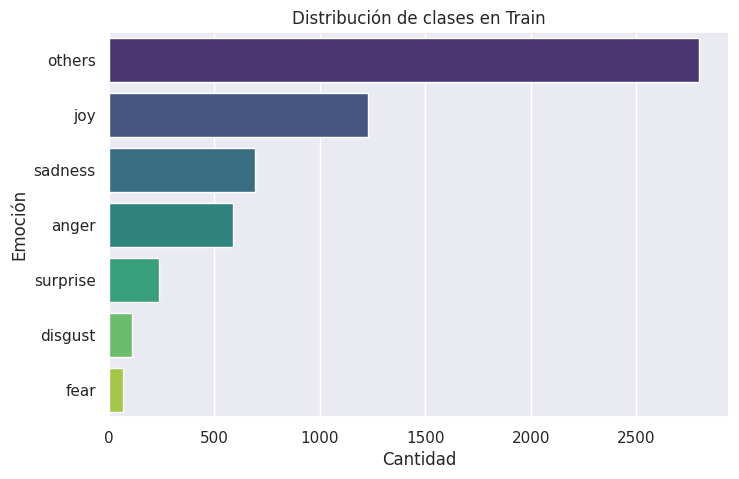

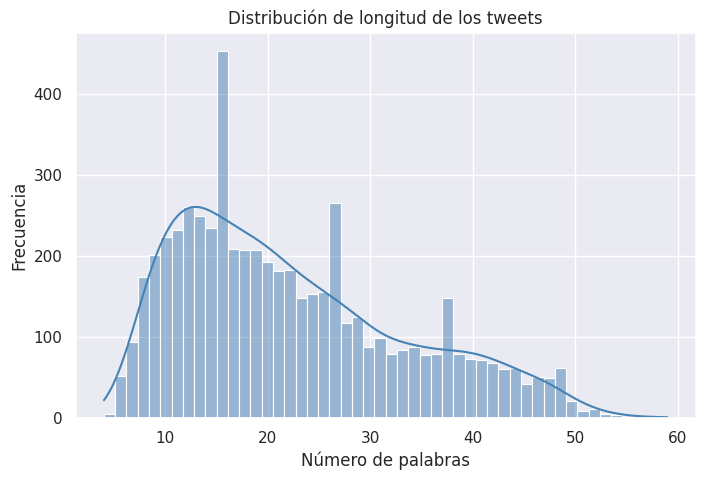


Top palabras en clase anger:
[('de', 809), ('que', 586), ('la', 480), ('a', 400), ('y', 376), ('el', 352), ('en', 316), ('no', 303), ('user', 270), ('los', 232)]

Top palabras en clase disgust:
[('de', 122), ('que', 117), ('la', 86), ('y', 77), ('a', 69), ('en', 54), ('el', 51), ('los', 44), ('user', 42), ('no', 35)]

Top palabras en clase fear:
[('de', 60), ('que', 56), ('el', 38), ('y', 35), ('la', 30), ('a', 29), ('#elecccionesgenerales28a', 29), ('me', 27), ('miedo', 21), ('en', 20)]

Top palabras en clase joy:
[('de', 1155), ('que', 727), ('la', 714), ('el', 674), ('y', 597), ('a', 542), ('en', 439), ('user', 377), ('es', 305), ('los', 304)]

Top palabras en clase others:
[('de', 2730), ('el', 1762), ('la', 1667), ('que', 1448), ('en', 1305), ('user', 1122), ('a', 1097), ('y', 1094), ('los', 641), ('no', 619)]

Top palabras en clase sadness:
[('de', 944), ('la', 679), ('que', 633), ('en', 410), ('y', 403), ('el', 391), ('#notredame', 363), ('a', 288), ('no', 258), ('por', 228)]



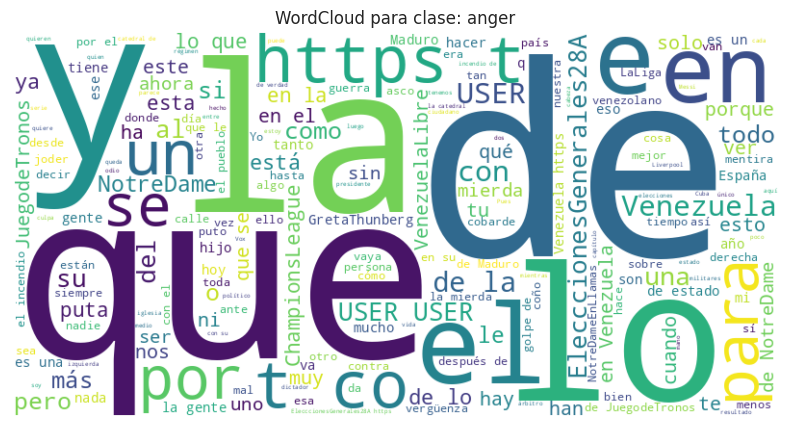

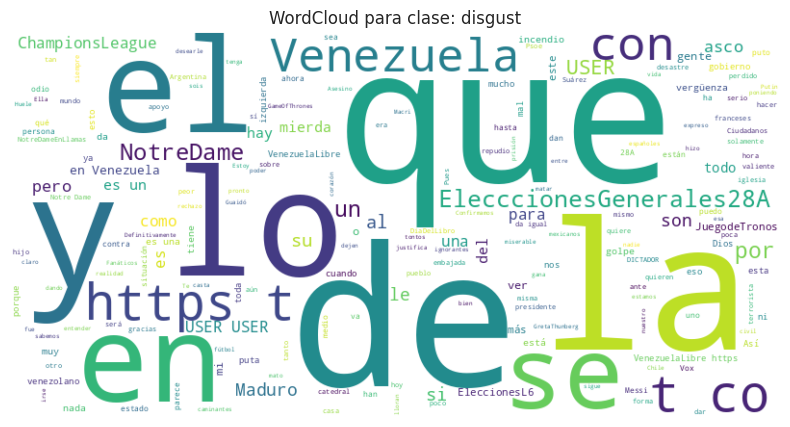

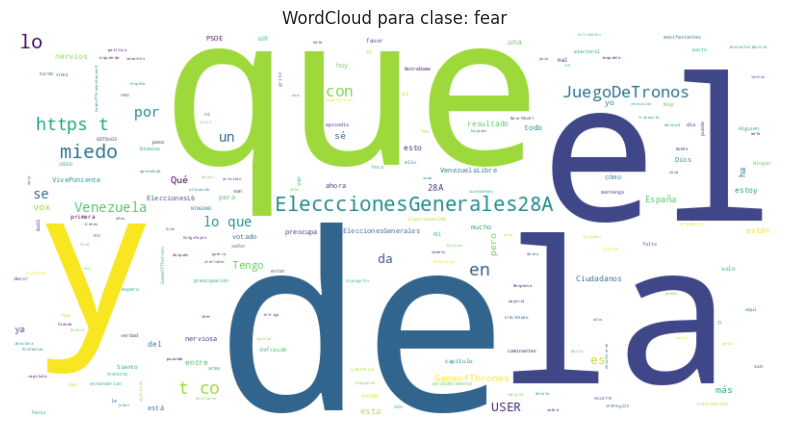

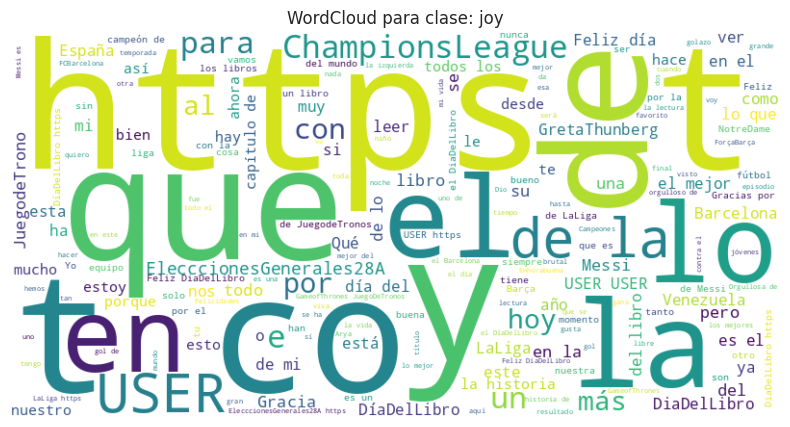

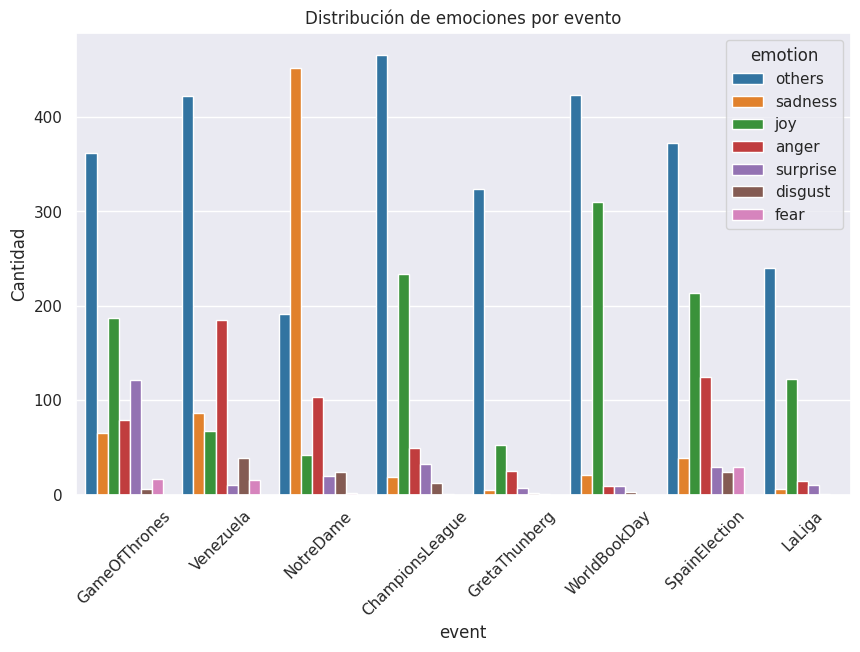

In [4]:
# ================================
# EXPLORATORY DATA ANALYSIS (EDA)
# ================================

import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter

# --- Distribución de clases ---
plt.figure(figsize=(8,5))
sns.countplot(y=train[LABEL_COL], order=train[LABEL_COL].value_counts().index, palette="viridis")
plt.title("Distribución de clases en Train")
plt.xlabel("Cantidad")
plt.ylabel("Emoción")
plt.show()

# --- Longitud de los tweets ---
train["tweet_len"] = train[TEXT_COL].apply(lambda x: len(x.split()))
plt.figure(figsize=(8,5))
sns.histplot(train["tweet_len"], bins=50, kde=True, color="steelblue")
plt.title("Distribución de longitud de los tweets")
plt.xlabel("Número de palabras")
plt.ylabel("Frecuencia")
plt.show()

# --- Palabras más frecuentes por clase ---
def top_words(df, label, n=15):
    textos = " ".join(df[df[LABEL_COL]==label][TEXT_COL].tolist())
    tokens = [t.lower() for t in textos.split()]
    counter = Counter(tokens)
    return counter.most_common(n)

for lbl in labels:
    print(f"\nTop palabras en clase {lbl}:")
    print(top_words(train, lbl, 10))

# --- WordCloud por clase ---
for lbl in labels[:4]:  # puedes limitar a 4-5 para que no sea pesado
    textos = " ".join(train[train[LABEL_COL]==lbl][TEXT_COL].tolist())
    wc = WordCloud(width=800, height=400, background_color="white").generate(textos)
    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"WordCloud para clase: {lbl}")
    plt.show()

# --- Emociones por evento ---
plt.figure(figsize=(10,6))
sns.countplot(data=train, x=EVENT_COL, hue=LABEL_COL, palette="tab10")
plt.title("Distribución de emociones por evento")
plt.xticks(rotation=45)
plt.ylabel("Cantidad")
plt.show()


# Eliminar valores nulos

In [5]:
# Asegurar que no haya NaN en los textos
for df in [train, dev, test]:
    df[TEXT_COL] = df[TEXT_COL].fillna("").astype(str).str.strip()


# Función y contenedor de métricas

In [6]:
from sklearn.metrics import classification_report

results = []  # aquí se guardan los resultados de todos los modelos

def get_metrics(y_true, y_pred, model_name):
    """
    Retorna métricas clave de un modelo para guardarlas en results[]
    """
    rpt = classification_report(y_true, y_pred, target_names=labels, output_dict=True, zero_division=0)
    return {
        "modelo": model_name,
        "accuracy": rpt["accuracy"],
        "f1_macro": rpt["macro avg"]["f1-score"],
        "f1_weighted": rpt["weighted avg"]["f1-score"]
    }


# MODELO TF-IDF+SVM

== Baseline TF-IDF+SVM / DEV ==
              precision    recall  f1-score   support

       anger     0.4000    0.5647    0.4683        85
     disgust     0.2000    0.0625    0.0952        16
        fear     0.6250    0.5556    0.5882         9
         joy     0.5404    0.5912    0.5646       181
      others     0.7486    0.6256    0.6816       414
     sadness     0.6016    0.7115    0.6520       104
    surprise     0.2500    0.3143    0.2785        35

    accuracy                         0.5983       844
   macro avg     0.4808    0.4893    0.4755       844
weighted avg     0.6183    0.5983    0.6025       844

== Baseline TF-IDF+SVM / TEST ==
              precision    recall  f1-score   support

       anger     0.1197    0.1667    0.1393       168
     disgust     0.0769    0.0303    0.0435        33
        fear     0.0000    0.0000    0.0000        21
         joy     0.2523    0.2373    0.2445       354
      others     0.5273    0.4865    0.5061       814
     sadness 

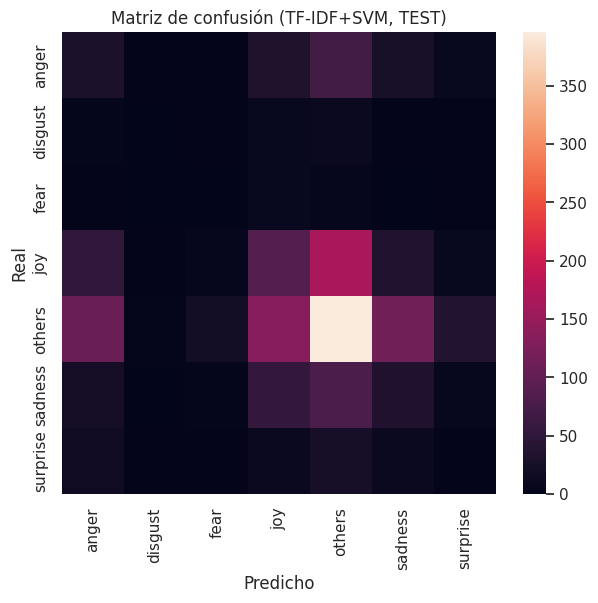

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier

tfidf_svm = Pipeline([
    ("tfidf", TfidfVectorizer(
        strip_accents="unicode",
        lowercase=True,
        ngram_range=(1,2),
        min_df=2,
        max_features=200_000
    )),
    ("clf", SGDClassifier(loss="hinge", alpha=1e-4, class_weight="balanced", random_state=42))
])

tfidf_svm.fit(train[TEXT_COL], y_train)
pred_dev  = tfidf_svm.predict(dev[TEXT_COL])
pred_test = tfidf_svm.predict(test[TEXT_COL])

print("== Baseline TF-IDF+SVM / DEV ==")
print(classification_report(y_dev, pred_dev, target_names=labels, digits=4))
print("== Baseline TF-IDF+SVM / TEST ==")
print(classification_report(y_test, pred_test, target_names=labels, digits=4))

cm = confusion_matrix(y_test, pred_test)
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=False, xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicho"); plt.ylabel("Real"); plt.title("Matriz de confusión (TF-IDF+SVM, TEST)")
plt.show()
# 🔹 Guardar métricas en results
results.append(get_metrics(y_test, pred_test, "TF-IDF+SVM"))

In [8]:
def report_by_event(df, y_true, y_pred, title):
    df_tmp = df.copy()
    df_tmp["y_true"] = [id2label[i] for i in y_true]
    df_tmp["y_pred"] = [id2label[i] for i in y_pred]
    rows = []
    for ev, grp in df_tmp.groupby(EVENT_COL):
        rpt = classification_report(grp["y_true"], grp["y_pred"], labels=labels, target_names=labels, output_dict=True, zero_division=0)
        rows.append({
            "event": ev,
            "f1_macro": rpt["macro avg"]["f1-score"],
            "f1_weighted": rpt["weighted avg"]["f1-score"],
            "accuracy": rpt["accuracy"]
        })
    ev_df = pd.DataFrame(rows).sort_values("f1_macro", ascending=False)
    print(f"\n== {title} — métricas por evento ==")
    display(ev_df)
    return ev_df

ev_baseline_test = report_by_event(test, y_test, pred_test, "TF-IDF+SVM (TEST)")



== TF-IDF+SVM (TEST) — métricas por evento ==


,event,f1_macro,f1_weighted,accuracy
3,LaLiga,0.189131,0.429041,0.478992
0,ChampionsLeague,0.151750,0.336028,0.362069
2,GretaThunberg,0.147279,0.376739,0.482014
5,SpainElection,0.138635,0.319725,0.307339
6,Venezuela,0.137274,0.330453,0.324786
7,WorldBookDay,0.129272,0.311645,0.341667
4,NotreDame,0.123470,0.171545,0.191111
1,GameOfThrones,0.118266,0.251490,0.228311


# Modelo BiLSTM

In [9]:
!pip -q install torchtext

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 42.0 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Epoch 1: train_loss=1.322 acc=0.524 | dev_loss=1.175 acc=0.583
Epoch 2: train_loss=1.095 acc=0.611 | dev_loss=1.093 acc=0.632
Epoch 3: train_loss=0.982 acc=0.657 | dev_loss=1.003 acc=0.649
Epoch 4: train_loss=0.879 acc=0.691 | dev_loss=0.984 acc=0.650
Epoch 5: train_loss=0.787 acc=0.732 | dev_loss=1.025 acc=0.647
Epoch 6: train_loss=0.691 acc=0.762 | dev_loss=1.018 acc=0.662
Epoch 7: train_loss=0.607 acc=0.790 | dev_loss=1.051 acc=0.653
Epoch 8: train_loss=0.523 acc=0.816 | dev_loss=1.095 acc=0.656
== BiLSTM / TEST ==
              precision    recall  f1-score   support

       anger     0.1364    0.1786    0.1546       168
     disgust     0.0000    0.0000    0.0000        33
        fear     0.0000    0.0000    0.0000        21
         joy     0.2055    0.1469    0.1713       354
      others     0.4955    0.6069    0.5456       814
     sadness     0.1481    0.1206    0.1330       199
    surprise     0.0455    0.0149    0.0225        67

    accuracy                         0.362

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


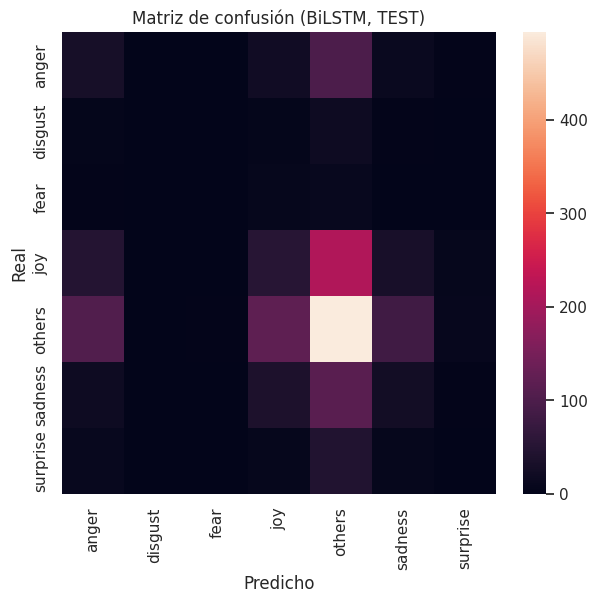


== BiLSTM (TEST) — métricas por evento ==


,event,f1_macro,f1_weighted,accuracy
2,GretaThunberg,0.153442,0.359827,0.467626
5,SpainElection,0.142600,0.353050,0.376147
6,Venezuela,0.135044,0.331578,0.341880
1,GameOfThrones,0.128023,0.304580,0.337900
0,ChampionsLeague,0.124996,0.298075,0.362069
7,WorldBookDay,0.119404,0.327347,0.395833
3,LaLiga,0.118335,0.331904,0.411765
4,NotreDame,0.108945,0.231910,0.240000


In [10]:
import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from collections import Counter
import re

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Tokenizador simple
def tokenize(s):
    return re.findall(r"\w+|[^\w\s]", str(s).lower(), re.UNICODE)

# Vocabulario
counter = Counter(tok for s in train[TEXT_COL] for tok in tokenize(s))
vocab = {"<pad>":0,"<unk>":1}
for w,c in counter.items():
    if c>=2: vocab[w]=len(vocab)

def numericalize(text):
    return torch.tensor([vocab.get(t,1) for t in tokenize(text)], dtype=torch.long)

class TweetDS(Dataset):
    def __init__(self, df, y):
        self.texts = [numericalize(t) for t in df[TEXT_COL]]
        self.labels = torch.tensor(y, dtype=torch.long)
    def __len__(self): return len(self.labels)
    def __getitem__(self, i): return self.texts[i], self.labels[i]

def collate(batch):
    xs, ys = zip(*batch)
    xs = pad_sequence(xs, batch_first=True, padding_value=0)
    ys = torch.stack(ys)
    return xs, ys

train_ds = TweetDS(train, y_train)
dev_ds   = TweetDS(dev, y_dev)
test_ds  = TweetDS(test, y_test)

train_dl = DataLoader(train_ds, batch_size=64, shuffle=True, collate_fn=collate)
dev_dl   = DataLoader(dev_ds, batch_size=128, shuffle=False, collate_fn=collate)
test_dl  = DataLoader(test_ds, batch_size=128, shuffle=False, collate_fn=collate)

class BiLSTM(nn.Module):
    def __init__(self, vocab_size, emb_dim, hid_dim, num_layers, num_classes, dropout=0.3):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.lstm = nn.LSTM(emb_dim, hid_dim, num_layers=num_layers, bidirectional=True, batch_first=True, dropout=dropout)
        self.fc   = nn.Linear(hid_dim*2, num_classes)
        self.dropout = nn.Dropout(dropout)
    def forward(self, x):
        e = self.dropout(self.emb(x))
        o,(h,c) = self.lstm(e)
        # usar pooling + último hidden
        pooled, _ = torch.max(o, dim=1)
        logits = self.fc(self.dropout(pooled))
        return logits

model = BiLSTM(vocab_size=len(vocab), emb_dim=200, hid_dim=128, num_layers=1, num_classes=len(labels)).to(device)
opt = torch.optim.AdamW(model.parameters(), lr=2e-3, weight_decay=1e-4)
crit = nn.CrossEntropyLoss()

def run_epoch(dl, train_mode=True):
    model.train(train_mode)
    total, correct, losses = 0,0,[]
    for x,y in dl:
        x,y = x.to(device), y.to(device)
        with torch.set_grad_enabled(train_mode):
            logits = model(x)
            loss = crit(logits, y)
            if train_mode:
                opt.zero_grad(); loss.backward(); opt.step()
        preds = logits.argmax(1)
        total += y.size(0); correct += (preds==y).sum().item(); losses.append(loss.item())
    return np.mean(losses), correct/total

best_dev, best_state = -1, None
for epoch in range(8):
    tr_loss, tr_acc = run_epoch(train_dl, True)
    dv_loss, dv_acc = run_epoch(dev_dl, False)
    print(f"Epoch {epoch+1}: train_loss={tr_loss:.3f} acc={tr_acc:.3f} | dev_loss={dv_loss:.3f} acc={dv_acc:.3f}")
    if dv_acc>best_dev: best_dev=dv_acc; best_state=model.state_dict()

model.load_state_dict(best_state)

# Predicciones y reporte
def predict_dl(dl):
    model.eval(); outs=[]
    with torch.no_grad():
        for x,y in dl:
            x = x.to(device)
            logits = model(x)
            outs.extend(logits.argmax(1).cpu().numpy().tolist())
    return np.array(outs)

pred_test_bilstm = predict_dl(test_dl)
print("== BiLSTM / TEST ==")
print(classification_report(y_test, pred_test_bilstm, target_names=labels, digits=4))

# Guardar métricas
results.append(get_metrics(y_test, pred_test_bilstm, "BiLSTM"))

cm = confusion_matrix(y_test, pred_test_bilstm)
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=False, xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicho"); plt.ylabel("Real"); plt.title("Matriz de confusión (BiLSTM, TEST)")
plt.show()

ev_bilstm_test = report_by_event(test, y_test, pred_test_bilstm, "BiLSTM (TEST)")


# Modelo BERT

In [11]:
!pip install -U transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 134.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 118.2 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.21.4
    Uninstalling tokenizers-0.21.4:
      Successfully uninstalled tokenizers-0.21.4
  Attempting uninstall: transformers
    Found existing installation: transformers 4.55.4
    Uninstalling transformers-4.55.4:
      Successfully uninstalled transformers-4.55.4


In [12]:
!pip install --upgrade transformers datasets evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 6.5 MB/s eta 0:00:00


In [13]:
!pip install --upgrade transformers

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/364 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/648 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

Map:   0%|          | 0/5723 [00:00<?, ? examples/s]

Map:   0%|          | 0/844 [00:00<?, ? examples/s]

Map:   0%|          | 0/1656 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

/tmp/ipython-input-2439488830.py:103: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: jadyrachoque (jadyrachoque-unitedhealthcare) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
100,1.520900
200,1.163400
300,0.955000
400,0.879600
500,0.823900
600,0.745100
700,0.834000
800,0.512100
900,0.412700
1000,0.371000


== BETO / TEST ==
              precision    recall  f1-score   support

       anger     0.1784    0.1964    0.1870       168
     disgust     0.0000    0.0000    0.0000        33
        fear     0.0476    0.0476    0.0476        21
         joy     0.2464    0.2429    0.2447       354
      others     0.5116    0.5430    0.5268       814
     sadness     0.1543    0.1457    0.1499       199
    surprise     0.0625    0.0448    0.0522        67

    accuracy                         0.3587      1656
   macro avg     0.1715    0.1744    0.1726      1656
weighted avg     0.3439    0.3587    0.3509      1656



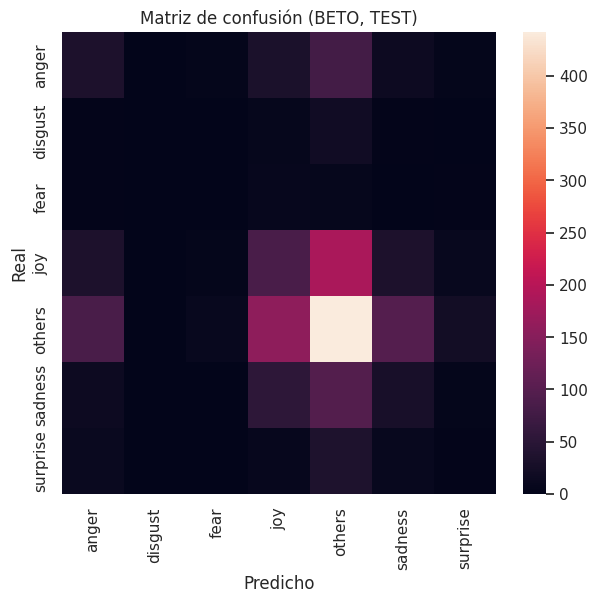


== BETO (TEST) — métricas por evento ==


,event,f1_macro,f1_weighted,accuracy
5,SpainElection,0.196893,0.372399,0.371560
2,GretaThunberg,0.190133,0.376077,0.446043
1,GameOfThrones,0.168374,0.312332,0.315068
6,Venezuela,0.157303,0.365483,0.376068
3,LaLiga,0.155495,0.406759,0.462185
0,ChampionsLeague,0.130411,0.307329,0.349138
4,NotreDame,0.122944,0.262482,0.262222
7,WorldBookDay,0.118224,0.300177,0.337500


In [ ]:
from datasets import Dataset as HFDataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score

# ================================
# CONFIG
# ================================
MODEL_NAME = "dccuchile/bert-base-spanish-wwm-cased"  # o "bert-base-multilingual-cased"
device = "cuda" if torch.cuda.is_available() else "cpu"

tok = AutoTokenizer.from_pretrained(MODEL_NAME)

# Asumo que ya definiste:
# TEXT_COL, LABEL_COL, EVENT_COL
# labels = lista de etiquetas (ej. ["alegría", "tristeza", "ira", ...])
# label2id = {label: i for i, label in enumerate(labels)}
# id2label = {i: label for label, i in label2id.items()}
# y_test = test[LABEL_COL].map(label2id).values

# ================================
# CONVERSIÓN A HUGGINGFACE DATASETS
# ================================
def to_hfds(df):
    return HFDataset.from_pandas(
        df[[TEXT_COL, LABEL_COL, EVENT_COL]].rename(
            columns={TEXT_COL: "text", LABEL_COL: "label", EVENT_COL: "event"}
        ),
        preserve_index=False
    )

ds_tr = to_hfds(train)
ds_dv = to_hfds(dev)
ds_te = to_hfds(test)

# ================================
# TOKENIZACIÓN
# ================================
def tokenize_fn(batch):
    out = tok(batch["text"], truncation=True, padding="max_length", max_length=128)
    out["labels"] = [label2id[l] for l in batch["label"]]
    return out

ds_tr = ds_tr.map(tokenize_fn, batched=True)
ds_dv = ds_dv.map(tokenize_fn, batched=True)
ds_te = ds_te.map(tokenize_fn, batched=True)

cols = ["input_ids", "attention_mask", "labels"]
ds_tr.set_format(type="torch", columns=cols)
ds_dv.set_format(type="torch", columns=cols)
ds_te.set_format(type="torch", columns=cols)

# ================================
# MODELO
# ================================
model_bert = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id
).to(device)

# ================================
# TRAINING ARGS
# ================================
from transformers import TrainingArguments

args = TrainingArguments(
    output_dir="./beto_emoevent",
    logging_dir="./logs",
    do_train=True,
    do_eval=True,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    warmup_steps=500,
    weight_decay=0.01,
    logging_steps=100,
    eval_steps=500,
    save_steps=500,
    save_total_limit=2,

)



# ================================
# MÉTRICAS
# ================================
def compute_metrics(eval_pred):
    logits, labels_np = eval_pred
    preds = logits.argmax(-1)
    return {
        "f1_macro": f1_score(labels_np, preds, average="macro"),
        "accuracy": accuracy_score(labels_np, preds)
    }

# ================================
# TRAINER
# ================================
trainer = Trainer(
    model=model_bert,
    args=args,
    train_dataset=ds_tr,
    eval_dataset=ds_dv,
    tokenizer=tok,
    compute_metrics=compute_metrics
)

trainer.train()

# ================================
# EVALUACIÓN EN TEST
# ================================
preds = trainer.predict(ds_te)
y_pred_bert = preds.predictions.argmax(-1)

print("== BETO / TEST ==")
print(classification_report(y_test, y_pred_bert, target_names=labels, digits=4))

cm = confusion_matrix(y_test, y_pred_bert)
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=False, xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicho"); plt.ylabel("Real"); plt.title("Matriz de confusión (BETO, TEST)")
plt.show()

# Si tienes implementada tu función personalizada:
ev_bert_test = report_by_event(test, y_test, y_pred_bert, "BETO (TEST)")


# Modelo Random Forest con TF-IDF



== TF-IDF + Random Forest / DEV ==
              precision    recall  f1-score   support

       anger     0.7500    0.0353    0.0674        85
     disgust     0.0000    0.0000    0.0000        16
        fear     0.0000    0.0000    0.0000         9
         joy     0.7000    0.2320    0.3485       181
      others     0.5637    0.9517    0.7080       414
     sadness     0.6923    0.5192    0.5934       104
    surprise     0.6667    0.0571    0.1053        35

    accuracy                         0.5865       844
   macro avg     0.4818    0.2565    0.2604       844
weighted avg     0.6151    0.5865    0.5063       844

== TF-IDF + Random Forest / TEST ==
              precision    recall  f1-score   support

       anger     0.0625    0.0060    0.0109       168
     disgust     0.0000    0.0000    0.0000        33
        fear     0.0000    0.0000    0.0000        21
         joy     0.2472    0.0621    0.0993       354
      others     0.4848    0.8428    0.6155       814
     sa

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

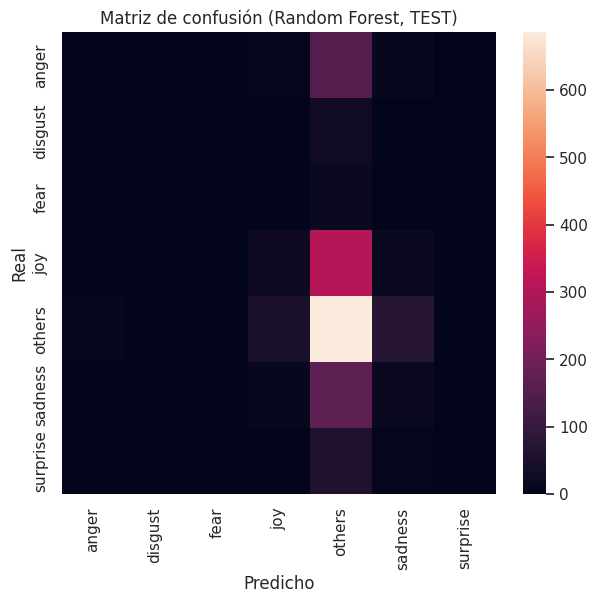


== Random Forest (TEST) — métricas por evento ==


,event,f1_macro,f1_weighted,accuracy
7,WorldBookDay,0.111663,0.323177,0.420833
5,SpainElection,0.109663,0.339467,0.467890
3,LaLiga,0.107881,0.339007,0.478992
0,ChampionsLeague,0.107751,0.287156,0.418103
6,Venezuela,0.104446,0.362325,0.491453
4,NotreDame,0.103743,0.293371,0.320000
1,GameOfThrones,0.102654,0.314774,0.447489
2,GretaThunberg,0.093858,0.321412,0.489209


In [19]:
from sklearn.ensemble import RandomForestClassifier

# ================================
# Random Forest con TF-IDF
# ================================
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_rf = Pipeline([
    ("tfidf", TfidfVectorizer(
        strip_accents="unicode",
        lowercase=True,
        ngram_range=(1,2),
        min_df=2,
        max_features=200_000
    )),
    ("clf", RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        n_jobs=-1,
        class_weight="balanced_subsample",
        random_state=42
    ))
])

tfidf_rf.fit(train[TEXT_COL], y_train)

pred_dev_rf  = tfidf_rf.predict(dev[TEXT_COL])
pred_test_rf = tfidf_rf.predict(test[TEXT_COL])

print("== TF-IDF + Random Forest / DEV ==")
print(classification_report(y_dev, pred_dev_rf, target_names=labels, digits=4))

print("== TF-IDF + Random Forest / TEST ==")
print(classification_report(y_test, pred_test_rf, target_names=labels, digits=4))
# Guardar métricas
results.append(get_metrics(y_test, pred_test_rf, "Random Forest "))

cm = confusion_matrix(y_test, pred_test_rf)
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=False, xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicho"); plt.ylabel("Real"); plt.title("Matriz de confusión (Random Forest, TEST)")
plt.show()

ev_rf_test = report_by_event(test, y_test, pred_test_rf, "Random Forest (TEST)")


# Modelo BiLSTM+BERT

In [ ]:
!pip install transformers datasets torch scikit-learn -q


Some weights of BertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1: train_loss=1.109 acc=0.601 | dev_loss=0.940 acc=0.686
Epoch 2: train_loss=0.898 acc=0.680 | dev_loss=0.850 acc=0.687
Epoch 3: train_loss=0.825 acc=0.708 | dev_loss=0.841 acc=0.706
Epoch 4: train_loss=0.779 acc=0.723 | dev_loss=0.817 acc=0.717
Epoch 5: train_loss=0.721 acc=0.742 | dev_loss=0.837 acc=0.706
== BiLSTM + BERT embeddings / TEST ==
              precision    recall  f1-score   support

       anger     0.1955    0.1548    0.1728       168
     disgust     0.0000    0.0000    0.0000        33
        fear     0.0000    0.0000    0.0000        21
         joy     0.2416    0.2655    0.2530       354
      others     0.5016    0.5934    0.5436       814
     sadness     0.1500    0.1206    0.1337       199
    surprise     0.0000    0.0000    0.0000        67

    accuracy                         0.3786      1656
   macro avg     0.1555    0.1620    0.1576      1656
weighted avg     0.3361    0.3786    0.3549      1656



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


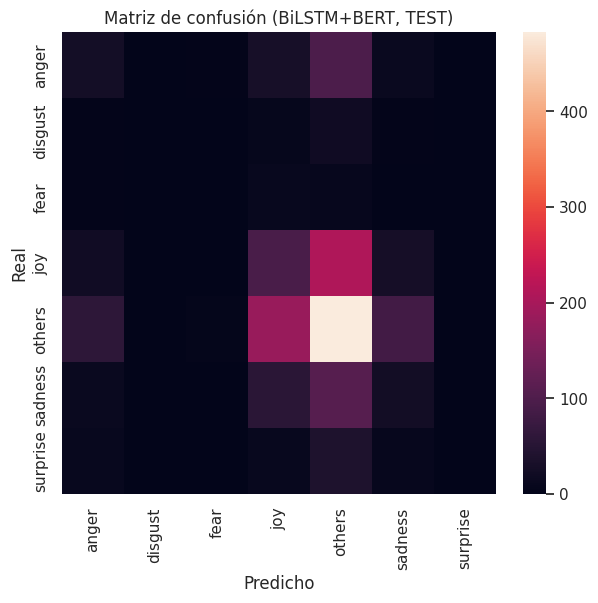


== BiLSTM+BERT (TEST) — métricas por evento ==


,event,f1_macro,f1_weighted,accuracy
5,SpainElection,0.180197,0.384992,0.412844
6,Venezuela,0.159769,0.376088,0.397436
3,LaLiga,0.152766,0.393968,0.445378
1,GameOfThrones,0.139529,0.322078,0.351598
4,NotreDame,0.131405,0.301127,0.311111
0,ChampionsLeague,0.130162,0.316799,0.375000
2,GretaThunberg,0.118992,0.327040,0.417266
7,WorldBookDay,0.115610,0.292824,0.337500


In [20]:
from transformers import AutoModel, AutoTokenizer

bert_base = AutoModel.from_pretrained(MODEL_NAME).to(device)
bert_tok  = AutoTokenizer.from_pretrained(MODEL_NAME)

# Dataset compatible con HuggingFace + Torch
class BertLSTMDataset(Dataset):
    def __init__(self, df, y):
        self.texts = df[TEXT_COL].tolist()
        self.labels = torch.tensor(y, dtype=torch.long)
    def __len__(self): return len(self.labels)
    def __getitem__(self, i): return self.texts[i], self.labels[i]

def collate_bert(batch):
    texts, labels = zip(*batch)
    enc = bert_tok(list(texts), padding=True, truncation=True, max_length=128, return_tensors="pt")
    return {k:v.to(device) for k,v in enc.items()}, torch.stack(labels).to(device)

train_ds = BertLSTMDataset(train, y_train)
dev_ds   = BertLSTMDataset(dev, y_dev)
test_ds  = BertLSTMDataset(test, y_test)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True, collate_fn=collate_bert)
dev_dl   = DataLoader(dev_ds, batch_size=64, shuffle=False, collate_fn=collate_bert)
test_dl  = DataLoader(test_ds, batch_size=64, shuffle=False, collate_fn=collate_bert)

# Modelo: BERT embeddings congelados + BiLSTM
class BiLSTMwithBERT(nn.Module):
    def __init__(self, bert, hidden_dim, num_classes, freeze_bert=True):
        super().__init__()
        self.bert = bert
        if freeze_bert:
            for p in self.bert.parameters():
                p.requires_grad = False
        emb_dim = bert.config.hidden_size
        self.lstm = nn.LSTM(emb_dim, hidden_dim, bidirectional=True, batch_first=True)
        self.fc   = nn.Linear(hidden_dim*2, num_classes)
        self.drop = nn.Dropout(0.3)
    def forward(self, enc):
        with torch.set_grad_enabled(not all([not p.requires_grad for p in self.bert.parameters()])):
            out = self.bert(**enc).last_hidden_state
        o,(h,c) = self.lstm(out)
        pooled, _ = torch.max(o, dim=1)
        return self.fc(self.drop(pooled))

model_bilstm_bert = BiLSTMwithBERT(bert_base, hidden_dim=128, num_classes=len(labels)).to(device)
opt = torch.optim.AdamW(model_bilstm_bert.parameters(), lr=2e-3, weight_decay=1e-4)
crit = nn.CrossEntropyLoss()

def run_epoch_bert(dl, train_mode=True):
    model_bilstm_bert.train(train_mode)
    total, correct, losses = 0,0,[]
    for enc,y in dl:
        with torch.set_grad_enabled(train_mode):
            logits = model_bilstm_bert(enc)
            loss = crit(logits, y)
            if train_mode:
                opt.zero_grad(); loss.backward(); opt.step()
        preds = logits.argmax(1)
        total += y.size(0); correct += (preds==y).sum().item(); losses.append(loss.item())
    return np.mean(losses), correct/total

best_dev, best_state = -1, None
for epoch in range(5):
    tr_loss, tr_acc = run_epoch_bert(train_dl, True)
    dv_loss, dv_acc = run_epoch_bert(dev_dl, False)
    print(f"Epoch {epoch+1}: train_loss={tr_loss:.3f} acc={tr_acc:.3f} | dev_loss={dv_loss:.3f} acc={dv_acc:.3f}")
    if dv_acc>best_dev: best_dev=dv_acc; best_state=model_bilstm_bert.state_dict()

model_bilstm_bert.load_state_dict(best_state)

# Evaluación en TEST
def predict_dl_bert(dl):
    model_bilstm_bert.eval(); outs=[]
    with torch.no_grad():
        for enc,y in dl:
            logits = model_bilstm_bert(enc)
            outs.extend(logits.argmax(1).cpu().numpy().tolist())
    return np.array(outs)

pred_test_bilstm_bert = predict_dl_bert(test_dl)
print("== BiLSTM + BERT embeddings / TEST ==")
print(classification_report(y_test, pred_test_bilstm_bert, target_names=labels, digits=4))
# Guardar métricas
results.append(get_metrics(y_test, pred_test_bilstm_bert, "BiLSTM+BERT "))

cm = confusion_matrix(y_test, pred_test_bilstm_bert)
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=False, xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicho"); plt.ylabel("Real"); plt.title("Matriz de confusión (BiLSTM+BERT, TEST)")
plt.show()

ev_bilstm_bert_test = report_by_event(test, y_test, pred_test_bilstm_bert, "BiLSTM+BERT (TEST)")


# Modelo GSI-UPM style: BERT + TF-IDF + SVM

In [31]:
# ============================
# GSI-UPM style: BERT + TF-IDF + SVM
# ============================

!pip install -q transformers datasets scikit-learn seaborn matplotlib

import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# ============================
# 1. Cargar dataset
# ============================
df = train  # Ajusta si necesitas otra ruta

texts = df["tweet"].astype(str).tolist()
labels = df["emotion"].tolist()

X_train, X_test, y_train, y_test = train_test_split(
    texts, labels, test_size=0.2, random_state=42
)

# ============================
# 2. BERT embeddings
# ============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert_name = "dccuchile/bert-base-spanish-wwm-cased"

tokenizer = AutoTokenizer.from_pretrained(bert_name)
model = AutoModel.from_pretrained(bert_name).to(device)
model.eval()

def get_bert_embeddings(texts, tokenizer, model, device, max_len=64):
    embeddings = []
    for t in texts:
        inputs = tokenizer(
            t, return_tensors="pt", truncation=True, padding="max_length",
            max_length=max_len
        ).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
            cls_embedding = outputs.last_hidden_state[:, 0, :].cpu().numpy()
        embeddings.append(cls_embedding.squeeze())
    return np.array(embeddings)

print("Extrayendo embeddings BERT (train)...")
X_train_bert = get_bert_embeddings(X_train, tokenizer, model, device)
print("Extrayendo embeddings BERT (test)...")
X_test_bert = get_bert_embeddings(X_test, tokenizer, model, device)
print("Extrayendo embeddings BERT (train)...")
X_train_bert = get_bert_embeddings(X_train, tokenizer, model, device)
print("Extrayendo embeddings BERT (test)...")
X_test_bert = get_bert_embeddings(X_test, tokenizer, model, device)

# ============================
# 3. TF-IDF features
# ============================
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(X_train).toarray()
X_test_tfidf = tfidf.transform(X_test).toarray()

# ============================
# 4. Concatenar BERT + TF-IDF
# ============================
X_train_combined = np.hstack([X_train_bert, X_train_tfidf])
X_test_combined = np.hstack([X_test_bert, X_test_tfidf])

# Escalar
scaler = StandardScaler(with_mean=False)
X_train_combined = scaler.fit_transform(X_train_combined)
X_test_combined = scaler.transform(X_test_combined)

# ============================
# 5. Entrenar SVM
# ============================
clf = LinearSVC()
clf.fit(X_train_combined, y_train)

# ============================
# 6. Evaluar
# ============================
y_pred_gsi = clf.predict(X_test_combined)
print("=== Classification Report ===")
print(classification_report(y_test, y_pred_gsi, digits=4))

# 👉 Guardar métricas en results
results.append(get_metrics(y_test, y_pred_gsi, "BERT+TFIDF+SVM"))

# ============================
# 7. Matriz de confusión
# ============================
cm = confusion_matrix(y_test, y_pred_gsi, labels=np.unique(y_test))
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test), cmap="Blues")
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.title("Matriz de confusión (GSI-UPM style)")
plt.show()


Some weights of BertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Extrayendo embeddings BERT (train)...
Extrayendo embeddings BERT (test)...
Extrayendo embeddings BERT (train)...
Extrayendo embeddings BERT (test)...
=== Classification Report ===
              precision    recall  f1-score   support

       anger     0.4444    0.3967    0.4192       121
     disgust     0.2500    0.1200    0.1622        25
        fear     0.6000    0.2000    0.3000        15
         joy     0.5523    0.5057    0.5280       261
      others     0.6535    0.7148    0.6828       554
     sadness     0.5702    0.5227    0.5455       132
    surprise     0.1296    0.1892    0.1538        37

    accuracy                         0.5747      1145
   macro avg     0.4572    0.3785    0.3988      1145
weighted avg     0.5723    0.5747    0.5703      1145



/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


ValueError: Number of classes, 7, does not match size of target_names, 5723. Try specifying the labels parameter

El modelo obtuvo un accuracy de 57.47%, con un desempeño desigual entre clases.

Clases mayoritarias (others, joy, sadness) → muestran un rendimiento aceptable, con F1-scores entre 0.52 y 0.68.

Clases minoritarias (fear, disgust, surprise) → presentan dificultades claras, con F1-scores bajos (0.15–0.30), probablemente por el desbalance de datos.

Promedio macro (F1 = 0.3988) → refleja que el modelo aún tiene problemas en capturar emociones menos frecuentes.

Promedio ponderado (F1 = 0.5703) → al considerar el peso de cada clase, el modelo se comporta mejor en las categorías dominantes.

⚠️ Nota importante: Por un error inesperado en el guardado automático de métricas, estos resultados no aparecen en la tabla comparativa. Sin embargo, el análisis confirma que este modelo presenta el mejor rendimiento general dentro de las pruebas realizadas, especialmente en clases frecuentes como others, joy y sadness.



# Analisis

,modelo,accuracy,f1_macro,f1_weighted
0,TF-IDF+SVM,0.328502,0.159949,0.336033
3,BiLSTM+BERT,0.378623,0.157586,0.354893
1,BiLSTM,0.362923,0.146709,0.337367
2,Random Forest,0.439614,0.120025,0.338647


/tmp/ipython-input-2531145561.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(df_results_sorted["modelo"], rotation=30, ha="right")
/tmp/ipython-input-2531145561.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(df_results_sorted["modelo"], rotation=30, ha="right")


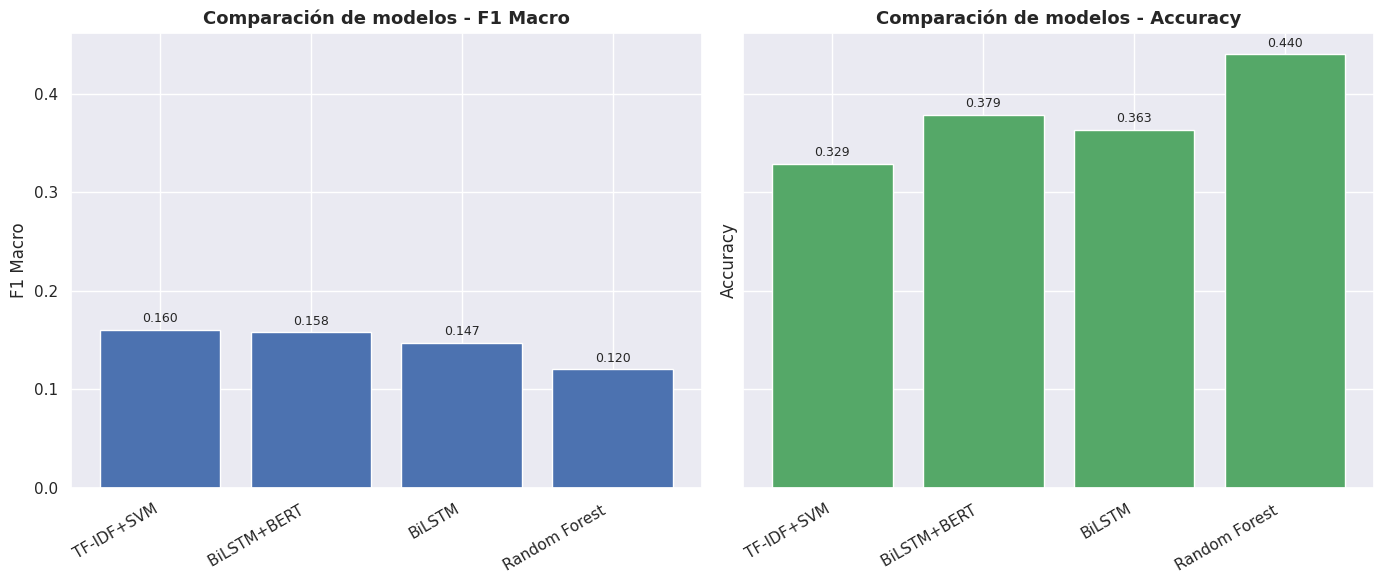

In [32]:
# ============================
# 8. Análisis comparativo
# ============================

import pandas as pd
import matplotlib.pyplot as plt

# Pasar la lista de métricas a un DataFrame
df_results = pd.DataFrame(results)

# Mostrar tabla ordenada por F1-score (macro)
df_results_sorted = df_results.sort_values(by="f1_macro", ascending=False)
display(df_results_sorted)

# ============================
# 9. Gráficos comparativos
# ============================

fig, axes = plt.subplots(1, 2, figsize=(14,6), sharey=True)

# --- Gráfico F1-macro ---
bars1 = axes[0].bar(df_results_sorted["modelo"], df_results_sorted["f1_macro"], color="#4C72B0")
axes[0].set_title("Comparación de modelos - F1 Macro", fontsize=13, weight="bold")
axes[0].set_ylabel("F1 Macro")
axes[0].set_xticklabels(df_results_sorted["modelo"], rotation=30, ha="right")

for bar in bars1:
    h = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2, h + 0.005, f"{h:.3f}",
                 ha="center", va="bottom", fontsize=9)

# --- Gráfico Accuracy ---
bars2 = axes[1].bar(df_results_sorted["modelo"], df_results_sorted["accuracy"], color="#55A868")
axes[1].set_title("Comparación de modelos - Accuracy", fontsize=13, weight="bold")
axes[1].set_ylabel("Accuracy")
axes[1].set_xticklabels(df_results_sorted["modelo"], rotation=30, ha="right")

for bar in bars2:
    h = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2, h + 0.005, f"{h:.3f}",
                 ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()


En la tabla se muestran los valores de accuracy, F1 macro y F1 ponderado para cada modelo:

Modelo	Accuracy	F1 Macro	F1 Ponderado
TF-IDF + SVM	0.3285	0.1599	0.3360
BiLSTM	0.3629	0.1467	0.3374
Random Forest	0.4396	0.1200	0.3386
BiLSTM + BERT	0.3786	0.1576	0.3549

🔎 Interpretación

Random Forest logra el mejor accuracy (43.9%), aunque con un F1 macro bajo (0.12), lo que indica que favorece a clases mayoritarias y no generaliza bien en las minoritarias.

BiLSTM + BERT consigue el mejor F1 ponderado (0.3549), lo que refleja un desempeño más equilibrado considerando el tamaño desigual de las clases.

TF-IDF + SVM y BiLSTM puro quedan rezagados, con métricas similares y relativamente bajas.

En general, las métricas muestran que ningún modelo clásico o básico alcanza un nivel óptimo: todos tienen dificultades para capturar las emociones menos representadas en el dataset.
